This notebook prepares the raw texts extracted from thousands of retailer urls into a format which can be used for futher text data modelling.

In [1]:
import sys
import json, os
from pandas.io.json import json_normalize
from collections import Counter
import collections
import operator, pprint
import matplotlib.pyplot as plt

In [2]:
# Some initilisations - please change the file_dir to your working directory to read the file

file_dir = '/home/danyzix/Dissertation/Data'
retail_file = 'complete_retail_json.txt'

Retailer data was extracted using a webscrapping tool from a list or 77,536 urls from 415 major retailers across many English speaking countries across the globe. An API of a webcralwer was used to extract the data in json format. I however lost one of the json files after preprocessing so, this part of the analysis only has 55,575 urls. Full length of file will be used in the modelling part as I had saved the pre-processed file.

In [3]:
# Lets open the text data as a json object
os.path.join(file_dir, retail_file)
with open(os.path.join(file_dir, retail_file)) as json_file:  
    data1 = json.load(json_file)
json_file.close()

In [26]:
# lets look at one entry of the daw data extracted by the webcrawler
data1[0]

{'offerPrice': '£1,188.00',
 'flixLoaderPresent': '2162',
 'flixMinisitePresent': '',
 'regularPrice': '£1,348.00',
 'regularPriceDetails': {'symbol': '£', 'amount': 1348, 'text': '£1,348.00'},
 'availability': True,
 'type': 'product',
 'title': 'SAMSUNG DV80M5010QX/EU 8 kg Heat Pump Tumble Dryer & AddWash WW80K5410UX 8 kg 1400 Spin Washing Machine Bundle',
 'offerPriceDetails': {'symbol': '£', 'amount': 1188, 'text': '£1,188.00'},
 'specs': {'fluff_filter': 'Yes',
  'energy_consumption_per_cycle': '235 kWh',
  'energy_rating': 'A',
  'delay_timer': 'Yes, 24 hours',
  'type': 'Freestanding tumble dryer',
  'drying_capacity': '8 kg',
  'number_of_minutes_on_timer': '150 minutes',
  'manufacturers_guarantee': '2 years',
  'capacity': '8 kg',
  'recess_dimensions': '900 x 650 x 690 mm (H x W x D)',
  'boxed_dimensions': '884 x 666 x 695 mm (H x W x D)',
  'spin_speed': '1400 rpm',
  'installation': 'Please note this product should be installed by a qualified engineer, such as one of our 

The retail_file consists of many key-value pairs with each pair being certain section of a webpage such as Product Titles, Brands, Product Specs, etc. I'll demonstrate the data structure in the following the cells.

In [4]:
# Lets add an extra value that counts the number of of such key-value pairs in each row of data which is data for each url
for row in range(len(data1)):
    data1[row].update({'keys': len(data1[row].keys())})

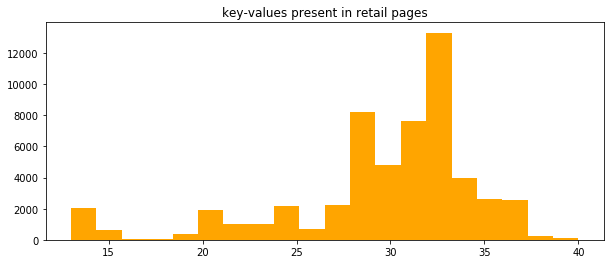

In [5]:
# A histogram plot to visualise the number of key-values per url
key_count = []
for row in range(len(data1)):
    key_count.append(data1[row]['keys'])
plt.figure(figsize=(10,4))
plt.hist(key_count, bins=20, color='orange')
plt.title('key-values present in retail pages')
plt.show()

We can see there's a very non-uniform spread of the key-value pairs, with a majority falling between 27 to 35.

In [6]:
# Some useful functions:

# get a list of unique column names
def get_unique_columns(data):
    columns = []
    for row in range(len(data)):
        for key in data[row].keys():
            columns.append(key)
    unique_columns = set(columns)
    return unique_columns

# count urls with a certain column present
def count_urls_with_column(column, data):
    count = 0
    for row in range(len(data)):
        if column in data[row].keys():
            count += 1
    return count

# delete a dictinary key from a dataset
def delete_key(key, data):
    for row in range(len(data)):
        if key in data1_subset[row].keys():
            del data1_subset[row][key]

In [7]:
# Let's look at the number of rows/urls of the retail data
len(data1)

55575

In [8]:
# A list of unique keys and the total number of such columns/keys in the data
unique_columns = get_unique_columns(data1)
print('number of columns: {}'.format(len(get_unique_columns(data1))))
print(unique_columns)

number of columns: 55
{'saveAmount', 'docId', 'images', 'seedUrlHash32', 'parentUrlDocId', 'flixInpagePresent', 'breadcrumb', 'gburl', 'multipleProducts', 'flixHotspotPresent', 'flixMinisiteButton2', 'keys', 'regularPriceDetails', 'humanLanguage', 'regularPrice', 'flixMinisiteButtonA', 'cspecs', 'flixEAN', 'flixLoaderPresent', 'flixMinisiteButton1', 'offerPriceDetails', 'normalizedSpecs', 'specs', 'sku', 'text', 'prefixCode', 'type', 'productId', 'priceRange', 'quantityPrices', 'productOrigin', 'flixMinisiteButton3', 'saveAmountDetails', 'title', 'category', 'offerPrice', 'flixProductID', 'is_boxed', 'resolvedPageUrl', 'diffbotUri', 'mpn', 'pageUrl', 'discussion', 'upc', 'test', 'flixMinisiteButton4', 'flixMinisiteButtonC', 'brand', 'flixMPN', 'flixMinisitePresent', 'timestamp', 'lastCrawlTimeUTC', 'availability', 'isbn', 'flixMinisiteButtonB'}


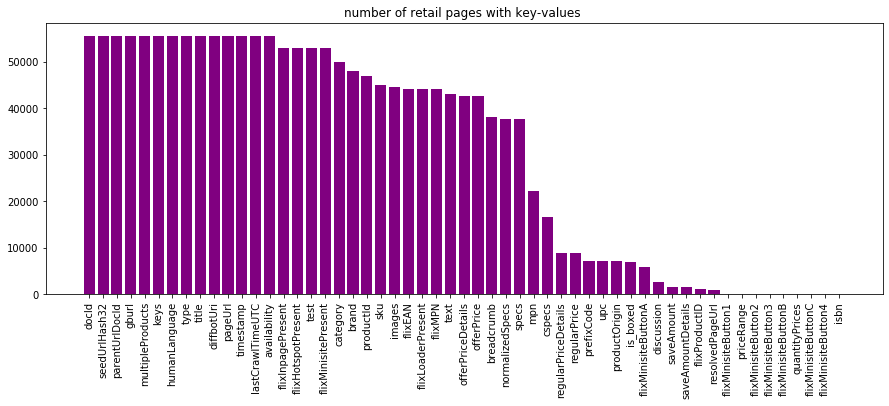

In [9]:
# Lets look at the number of data present in each column
columns={}
for key in unique_columns:
    columns[key] = count_urls_with_column(key, data1)
    
# plot the column data count in descending order
column_count = Counter(columns)
column_count_sorted_tuple = sorted(column_count.items(), key=lambda kv:kv[1], reverse=True) 
column_count_sorted = collections.OrderedDict(column_count_sorted_tuple)

plt.figure(figsize=(15,5))
plt.bar(column_count_sorted.keys(), column_count_sorted.values(), color='purple')
plt.xticks(rotation=90)
plt.title('number of retail pages with key-values ')
plt.show()

We can see there are few columns which are present in almost every url and few that are rarely there. Because of my domain knowledge, I know which columns are useful and which are not. In the following steps, I'll clean the data and keep only the columns which will be useful for this project

In [10]:
# list of bad columns - to be ignored
bad_columns = ['flixMinisiteButtonA','saveAmountDetails','flixMinisiteButton2','prefixCode','offerPrice','priceRange', 
               'parentUrlDocId','docId','humanLanguage','flixHotspotPresent', 'flixLoaderPresent','keys','regularPriceDetails',
               'flixMinisiteButtonB','flixMinisitePresent','images','flixInpagePresent','lastCrawlTimeUTC','is_boxed',
               'productOrigin','flixMinisiteButton4','flixMinisiteButton3','saveAmount','flixProductID','discussion',
               'flixMinisiteButtonC','diffbotUri','availability','type','resolvedPageUrl','seedUrlHash32','regularPriceDetails',
               'timestamp','flixMinisiteButton1','gburl','isbn','quantityPrices','multipleProducts','test','normalizedSpecs', 
              'offerPriceDetails','breadcrumb','regularPrice']

# list of columns to be used 
print([x for x in unique_columns if x not in bad_columns])

['cspecs', 'flixEAN', 'specs', 'sku', 'text', 'productId', 'title', 'category', 'mpn', 'pageUrl', 'upc', 'brand', 'flixMPN']


In [11]:
# Lets subset data with without the bad columns
data1_subset = []
temp = []
for row in range(len(data1)):
    temp = dict((key,data1[row][key]) for key in data1[row].keys() if key not in bad_columns)
    data1_subset.append(temp)

In [12]:
# Just to have an idea, lets look at the number of times a few columns appear in the new data-set
count_urls_with_column('pageUrl', data1_subset), count_urls_with_column('text', data1_subset)

(55575, 43075)

In [13]:
# Lets randomly look at one of the rows of the data to see the data structure
data1_subset[10095]

{'title': 'SanDisk SDCZ50-032G-FFP Cruzer Blade 32GB USB 2.0 Flash Drive for Mac and PC',
 'specs': {'storage_capacity': '32GB',
  'format': 'USB Flash Drive',
  'mpn': 'SDCZ50-032G-FFP',
  'type': 'USB Flash Drives',
  'interface': 'USB',
  'features': '32GB Storage, USB 2.0, Flash Drive',
  'condition': 'New',
  'colour': 'Black/Red',
  'ean': '619659069193',
  'series': 'USB Flash Drive',
  'usb_specification': 'USB 2.0',
  'warranty': '2 Years (Manufacturer)',
  'model': 'Cruzer Blade',
  'sku': 'SANDISK-008',
  'brand': 'SanDisk'},
 'flixEAN': '619659069193',
 'text': "Enjoy Ample Capacities and Maximum Portability\nWith its stylish, compact design and generous capacity, the Cruzer Blade USB Flash Drive makes it easy to back up, transfer, and share your files. Available in capacities of 32GB. This USB drive lets you carry your photos, movies, music, and personal data wherever you go.\nCompact Design for Maximum Portability\nThe Cruzer Blade USB Flash Drive features a compact desig

As we can see from above some of key-values in the data are in a nested json format, e.g. the 'specs' and 'cspecs'. So I'll reverse the nested json key-values and form a dictionary with just one level of key-value pair in the following cells.

Next I will convert each 'specs' and 'cspecs' section to one list of strings, adding a new line between each of the nested key-value pairs. Then I'll delete them, keeping the newly cleaned 'clean_specs' and 'clean_specs' instead. I will also re-order the structure of the data so that more important columns appear higher up in the data.

In [20]:
# textify cspecs and add a new column clean_cspecs where the cleaned data is stored
for row in range(len(data1_subset)):
    if 'cspecs' in data1_subset[row].keys():
        cspecs = []
        for i in range(len(data1_subset[row]['cspecs'][0]['features'])):
            keys = []
            for key,value in data1_subset[row]['cspecs'][0]['features'][i].items():
                # remove new line \n
                value = value.splitlines() 
                # convert list to string
                value = " ".join(value).strip('-')   #.replace('-','') cam be used to replace hyphens if needed 
                keys.append(value)
            # convert list to a string and add a new line
            text = " ".join(keys) + '\n'
            cspecs.append(text)
        cspecs = " ".join(cspecs)
        data1_subset[row].update({'clean_cspecs': cspecs})
        
# textify specs and add a new column clean_specs where the cleaned data is stored
for row in range(len(data1_subset)):
    if 'specs' in data1_subset[row].keys():
        specs = []
        for key,value in data1_subset[row]['specs'].items():
            temp = (key,value)
            temp = " ".join(temp) + '\n'
            specs.append(temp)
        specs = " ".join(specs)
        data1_subset[row].update({'clean_specs': specs})

In [18]:
# I can navigate the nested structure like this to access the final values
data1_subset[10095]['specs']['storage_capacity']

'32GB'

In [25]:
# Lets look at the 'specs' of the same url above
data1_subset[10055]['clean_specs']

'drying_performance_class A\n glass_care_40 Yes\n intensive_70 Yes\n type Compact Dishwasher\n normal_65 Yes\n eco_55 Yes\n anti_flood_device Floating Switch\n noise_level_db 50\n wash_performance_class A\n model FSE21200P\n party_programme_20_minutes Yes\n brand AEG\n quick_plus_50 Yes\n temperature_settings 4\n delay_start Yes\n depth_mm 500\n energy_efficiency_class A+\n annual_energy_consumption_kwh 174\n programmes 6\n time_remaining_indiator Yes\n place_settings 6\n width_mm 550\n salt_aid_indicator Yes\n colour Black Control Panel\n rinse_aid_indicator Yes\n annual_water_consumption_litres 1820\n height_mm 438\n'

In [21]:
# lets remove the specs and cspecs columns from the data
delete_key('specs',data1_subset)
delete_key('cspecs',data1_subset)
print('remaining columns: \n{}'.format(get_unique_columns(data1_subset)))

remaining columns: 
{'productId', 'brand', 'flixMPN', 'text', 'upc', 'mpn', 'clean_specs', 'title', 'flixEAN', 'category', 'clean_cspecs', 'pageUrl', 'sku'}


In [22]:
# reorder the data in the follwing order of the columns
desired_order_keys = ['title','pageUrl','category','brand','mpn','flixEAN','sku','flixMPN','upc','productId','clean_specs',
                     'clean_cspecs','text']
data1_subset_new = []
for row in range(len(data1_subset)):
    my_ordered_dict = collections.OrderedDict(data1_subset[row])
    for key in desired_order_keys:
        try:
            my_ordered_dict[key] = my_ordered_dict.pop(key)
        except KeyError: 
            pass    
    data1_subset_new.append(my_ordered_dict) 

Finally we have a clean data structure in a dictionary format with just one level of key-value pairs. Lets visualise how the same url data will look now.

In [19]:
for keys, values in data1_subset_new[195].items():
    print(keys,':',values)

title : SAMSUNG DV80M5010QX/EU 8 kg Heat Pump Tumble Dryer - Graphite + ecobubble WW80J5555FX/EU 8 kg 1400 Spin Washing Machine - Graphite
pageUrl : https://www.currys.co.uk/gbuk/household-appliances/laundry/tumble-dryers/samsung-dv80m5010qx-eu-8-kg-heat-pump-tumble-dryer-graphite-ecobubble-ww80j5555fx-eu-8-kg-1400-spin-washing-machine-graphite-b0444083-pdt.html
category : Appliances
brand : SAMSUNG
flixEAN : 
sku : B0444083
flixMPN : B0444083
productId : B0444083
clean_specs : fluff_filter Yes
 energy_consumption_per_cycle 235 kWh
 one-year_manufacturers_guarantee One-year manufacturer’s guarantee
 delay_timer Yes, 24 hours
 type Freestanding tumble dryer
 drying_capacity 8 kg
 number_of_minutes_on_timer 150 minutes
 manufacturers_guarantee 2 years
 capacity 9 kg
 recess_dimensions 900 x 650 x 690 mm (H x W x D)
 capacity_9_kg Capacity: 7 kg
 boxed_dimensions 884 x 666 x 695 mm (H x W x D)
 spin_speed 1400 rpm
 installation Please note this product should be installed by a qualified e

Now the cleaned file is saved as 'retail_hit_json.txt'. I cannot save the file I've worked so far as it'll overwrite my already preprocessed file which has 77536 url data. We can open that file below and verify the length is 77,536 not 55,575 as the one we've cleaned in this notebook.

In [20]:
# open the text data as a json object'
with open(os.path.join(file_dir, 'retail_hit_json.txt')) as json_file:  
    retail_hit = json.load(json_file)
json_file.close()
len(retail_hit)

77536